# mpg

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import datetime
import dateutil

In [3]:
# Constants
win_size = 15                # size of the rolling window for calculating mpg
l_per_gal = 4.54             # litres in a gallon
from_csv = False
from_sqlite = not from_csv   # csv or sqlite, mutually exclusive
debug = False                # controls whether debug output is included
db_name = 'mpg_VO62DVZ.sqlite'
table_name = 'mpg'

In [4]:
# read in mpg data from CSV
if from_csv:
    mpg_data = pd.read_csv('mpg.csv', header=0, index_col = 0, parse_dates=True, dayfirst=True, 
                          names=['Mileage', 'Fuel', 'Cost', 'Unit price'])

3:58: E251 unexpected spaces around keyword / parameter equals
3:60: E251 unexpected spaces around keyword / parameter equals
3:80: E501 line too long (95 > 79 characters)
3:96: W291 trailing whitespace
4:27: E128 continuation line under-indented for visual indent


In [5]:
# read in mpg data from sqlite db
if from_sqlite:
    engine = create_engine("sqlite:///"+db_name)
    mpg_data = pd.read_sql("SELECT * FROM "+table_name, engine)
    mpg_data.set_index('Date', inplace=True)
    mpg_data.index = pd.to_datetime(mpg_data.index, dayfirst=True)
    mpg_data.columns = ['Mileage', 'Fuel', 'Cost', 'Unit price']

In [6]:
# peek at the data
if debug:
    print(mpg_data.head())
    print(type(mpg_data.index))
    print(mpg_data.index)

In [7]:
# validate input
print('Input data\n----------')
print(mpg_data.head())
print(mpg_data.tail())

mpg_data['check_sum'] = (mpg_data['Fuel'] * mpg_data['Unit price']).round(decimals=2)
mpg_data['invalid'] = abs(mpg_data['Cost'] - mpg_data['check_sum']) > 0.01
invalid_mpg = mpg_data[mpg_data['invalid']]
print('\nInvalid entries\n---------------')
print(invalid_mpg)

6:80: E501 line too long (85 > 79 characters)


Input data
----------
            Mileage   Fuel   Cost  Unit price
Date                                         
2015-07-18    62549  25.91  30.29       1.169
2015-07-24    62971  32.41  37.56       1.159
2015-07-27    63344  30.15  34.94       1.159
2015-08-08    63808  39.69  45.21       1.139
2015-08-12    64213  30.78  34.44       1.119
            Mileage   Fuel   Cost  Unit price
Date                                         
2024-03-29   151381  43.44  65.99       1.519
2024-04-27   151849  41.25  64.31       1.559
2024-05-26   152267  37.75  56.59       1.499
2024-06-26   152726  40.01  57.97       1.449
2024-08-03   153159  38.87  56.71       1.459

Invalid entries
---------------
            Mileage   Fuel   Cost  Unit price  check_sum  invalid
Date                                                             
2016-06-05    78510  39.35  40.51       1.029      40.49     True
2017-03-18    91060  30.37  36.26       1.199      36.41     True
2018-06-04   107157  38.56  48.90    

In [8]:
mpg_data['mpg'] = (l_per_gal * mpg_data['Mileage'].diff(periods=win_size-1)/mpg_data['Fuel'].rolling(window=win_size).sum()).round(decimals=2)
if debug:
    print(mpg_data.head(2*win_size))
    print(mpg_data.tail(win_size))

1:80: E501 line too long (142 > 79 characters)


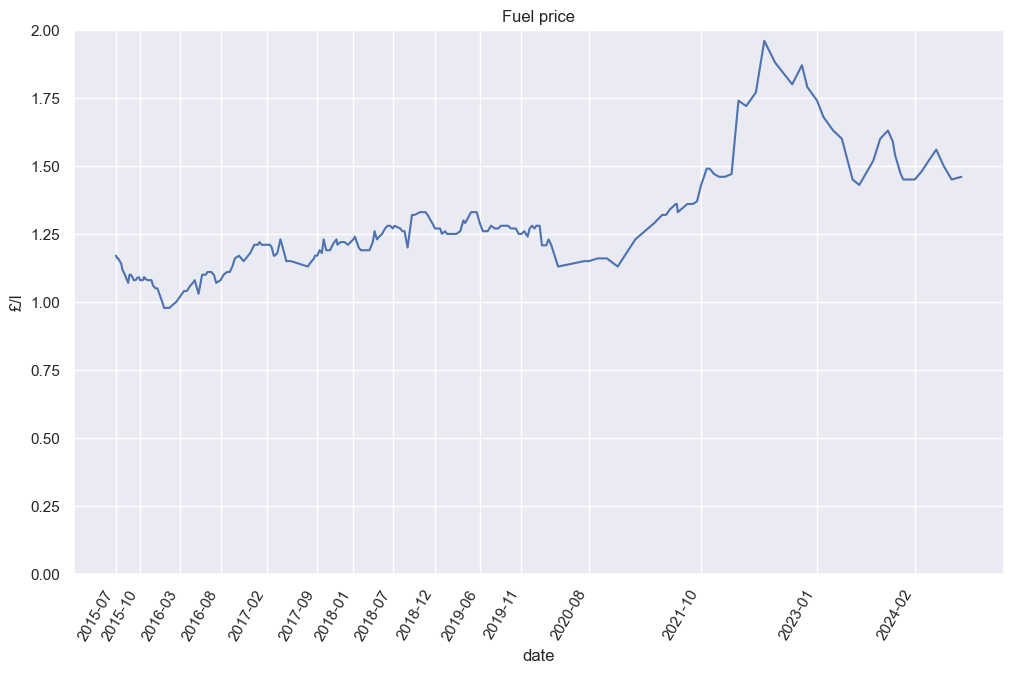

3:40: E231 missing whitespace after ','
6:16: E231 missing whitespace after ','


In [9]:
# plot fuel price
sns.set()
mpg_data['Unit price'].plot(figsize=(12,8))
_ = plt.xlabel('date')
_ = plt.ylabel('£/l')
_ = plt.ylim((0,2))
dates = mpg_data.index.to_numpy()[::win_size]
labels = np.datetime_as_string(dates, unit='M')
_ = plt.xticks(dates, labels, rotation=60)
_ = plt.title('Fuel price')

            Mileage   Fuel   Cost  Unit price  check_sum  invalid    mpg
Date                                                                    
2024-03-29   151381  43.44  65.99       1.519      65.99    False  44.25
2024-04-27   151849  41.25  64.31       1.559      64.31    False  44.76
2024-05-26   152267  37.75  56.59       1.499      56.59    False  45.12
2024-06-26   152726  40.01  57.97       1.449      57.97    False  45.05
2024-08-03   153159  38.87  56.71       1.459      56.71    False  45.31


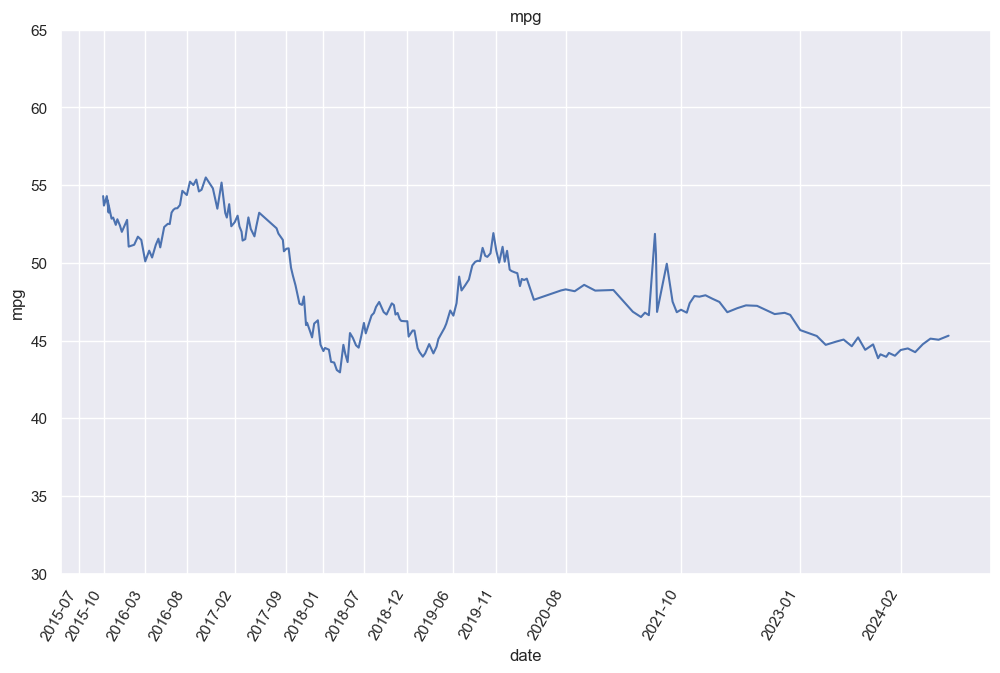

3:46: E231 missing whitespace after ','
6:17: E231 missing whitespace after ','
7:1: E265 block comment should start with '# '
8:80: E501 line too long (109 > 79 characters)
9:1: E265 block comment should start with '# '
16:1: E265 block comment should start with '# '


In [10]:
# plot mpg
sns.set()
mpg_data['mpg'][win_size-1:].plot(figsize=(12,8))
_ = plt.xlabel('date')
_ = plt.ylabel('mpg')
_ = plt.ylim((30,65))
#_ = plt.axis('tight')
# TODO more uniform sampling - does this go back to (upsampling) resampling and interpolation of eariler data
#dates = mpg_data.index.to_numpy()[::win_size]
if debug:
    print(dates)
labels = np.datetime_as_string(dates, unit='M')
_ = plt.xticks(dates, labels, rotation=60)
_ = plt.title('mpg')
print(mpg_data.tail())
#plt.grid(True)

Annual mileage

C:\Users\iaman\AppData\Local\Temp\ipykernel_17188\2269547830.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  annual_mileage = annual_mileage.resample('M').min()


            Annual mileage
Date                      
2024-04-30     5783.296146
2024-05-31     5917.417077
2024-06-30     6075.052995
2024-07-31     6000.815789
2024-08-31     5982.000000


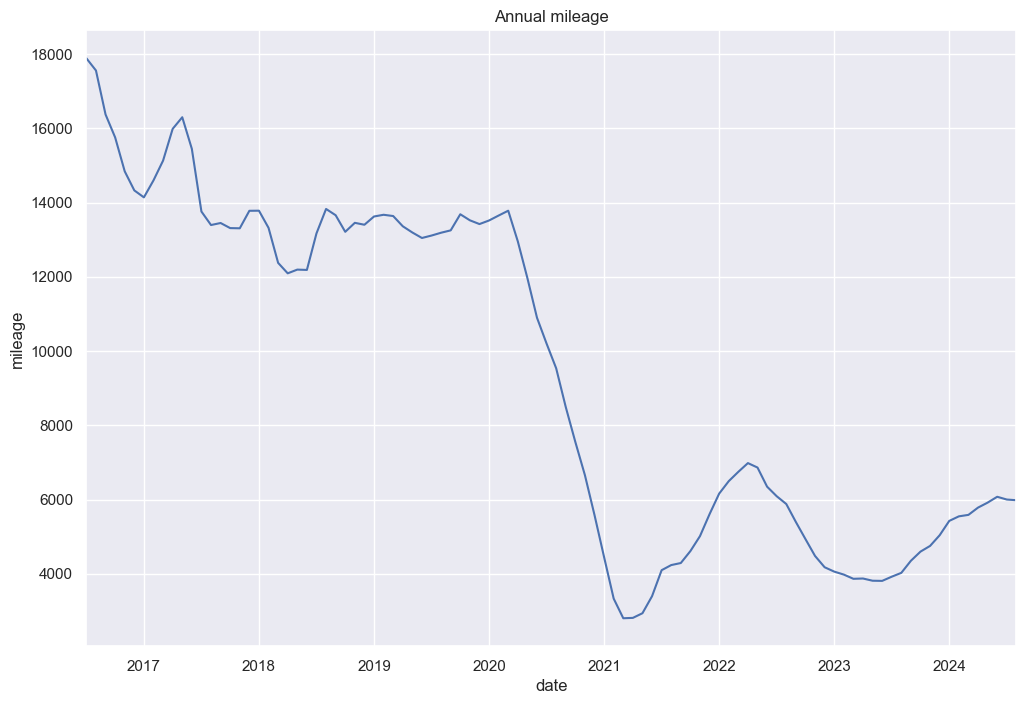

1:80: E501 line too long (84 > 79 characters)
10:32: E231 missing whitespace after ','


In [11]:
annual_mileage = pd.DataFrame(mpg_data['Mileage'].resample('D').interpolate('time'))
annual_mileage['Annual mileage'] = annual_mileage.diff(periods=365)
annual_mileage = annual_mileage.resample('M').min()
annual_mileage = annual_mileage.drop('Mileage', axis=1)
annual_mileage = annual_mileage[12:]                      # remove NaN rows
if debug:
    print(annual_mileage.head())
print(annual_mileage.tail())
sns.set()
annual_mileage.plot(figsize=(12,8), legend=False)
_ = plt.xlabel('date')
_ = plt.ylabel('mileage')
_ = plt.title('Annual mileage')

Monthly fuel spend (moving average)

C:\Users\iaman\AppData\Local\Temp\ipykernel_17188\2250153343.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_spend = pd.DataFrame(mpg_data['Cost'].resample('M').sum()).rolling(6, center=True).mean()


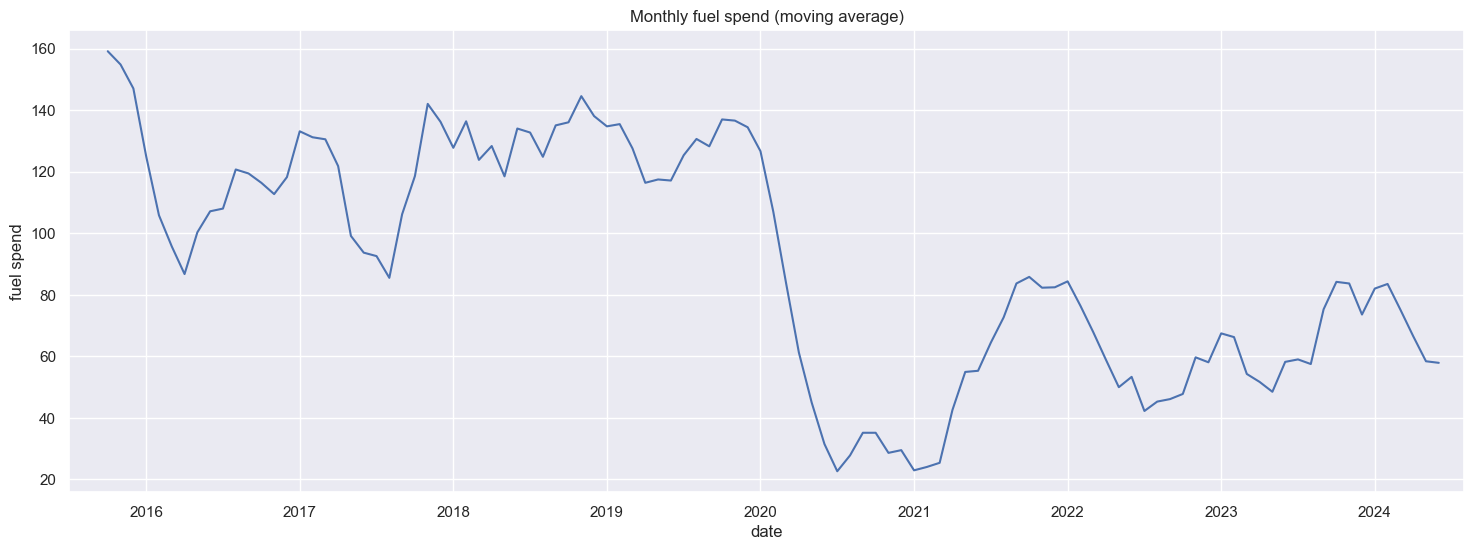

1:80: E501 line too long (97 > 79 characters)
6:31: E231 missing whitespace after ','


In [12]:
monthly_spend = pd.DataFrame(mpg_data['Cost'].resample('M').sum()).rolling(6, center=True).mean()
if debug:
    print(monthly_spend.head())
    print(monthly_spend.tail())
sns.set()
monthly_spend.plot(figsize=(18,6), legend=False)
_ = plt.xlabel('date')
_ = plt.ylabel('fuel spend')
_ = plt.title('Monthly fuel spend (moving average)')

In [13]:
mpg_data.tail()

,Mileage,Fuel,Cost,Unit price,check_sum,invalid,mpg
Date,,,,,,,
2024-03-29,151381,43.44,65.99,1.519,65.99,False,44.25
2024-04-27,151849,41.25,64.31,1.559,64.31,False,44.76
2024-05-26,152267,37.75,56.59,1.499,56.59,False,45.12
2024-06-26,152726,40.01,57.97,1.449,57.97,False,45.05
2024-08-03,153159,38.87,56.71,1.459,56.71,False,45.31
